<a href="https://colab.research.google.com/github/cristopher-d-delgado/image_classification_pneumonia/blob/main/mlp_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection on Chest X-Rays

In [1]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

In [2]:
# # Google Drive connection

# from google.colab import drive
# drive.mount('/content/drive/')

# Explore our Data & Preprocess

In [3]:
import os
# Create a path to the root folder and path to specific folders on my computer
# data_path = '/content/drive/MyDrive/Flatiron/phase4/chest_xray/chest_xray'
# data_path = 'data\chest_xray\chest_xray'
data_path = "data/chest_xray/"
#data_path = "data/CellData/chest_xray/"
data_path

# Specificy paths for train, test, val
train_folder = os.path.join(data_path, 'train/')
test_folder = os.path.join(data_path, 'test/')
val_folder = os.path.join(data_path, 'validation/')

# Specify paths for labels
train_normal = os.path.join(train_folder, 'NORMAL')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, "NORMAL")
test_pneumonia = os.path.join(test_folder, "PNEUMONIA")
val_normal = os.path.join(val_folder, "NORMAL")
val_pneumonia = os.path.join(val_folder, "PNEUMONIA")

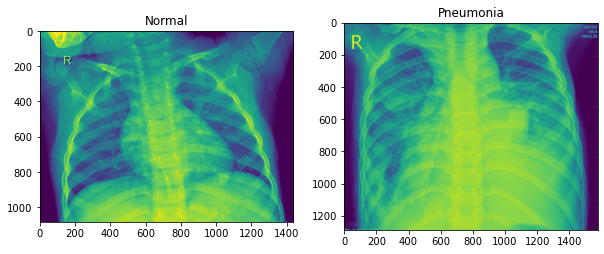

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Read images
# img1 = Image.open("/content/drive/MyDrive/Flatiron/phase4/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
# img2 = Image.open("/content/drive/MyDrive/Flatiron/phase4/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
# img1 = Image.open("data/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
# img2 = Image.open("data/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")

# img1 = Image.open(r"data\CellData\chest_xray\train\NORMAL\NORMAL-32326-0001.jpeg")
# img2 = Image.open(r"data\CellData\chest_xray\train\PNEUMONIA\BACTERIA-37006-0002.jpeg")


img1 = Image.open(r"data\chest_xray\train\NORMAL\NORMAL-32326-0001.jpeg")
img2 = Image.open(r"data\chest_xray\train\PNEUMONIA\BACTERIA-37006-0002.jpeg")

# Display images side by side
plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Normal')

# Plot the second image
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Pneumonia')

plt.show()

It seems that the images are not actually on the same size. Visually we can see the bacterial infection. We would have to preprocess the images to become the same size and also lower the scale since training a neuwral network is resource intensive. Lets explore how many images we have in each directory.

In [5]:
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(test_normal)), 'normal images in the testing set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the testing set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 1249 normal images in the training set
There are 3783 pneumonia images in the training set
________________________________________________________________________________________
There are 235 normal images in the testing set
There are 390 pneumonia images in the testing set
________________________________________________________________________________________
There are 100 normal images in the validation set
There are 100 pneumonia images in the validation set


Lets preprocess the images by resizing to (256, 256, 3)

In [7]:
from functions import process_data

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Preprocess data with our function
train_gen, test_gen, val_gen = process_data(256, 32, train_data_dir, test_data_dir, val_data_dir)

Found 5032 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


It seems the generators are working as expected. The main downside is that the image genertaor does not let us know what images are normal and pneumonia but its labeled for us as 1, 0. Lets take a batch of images and see what we see so we know what is Normal and Peneumonia.

Image dimensions: (256, 256, 3)


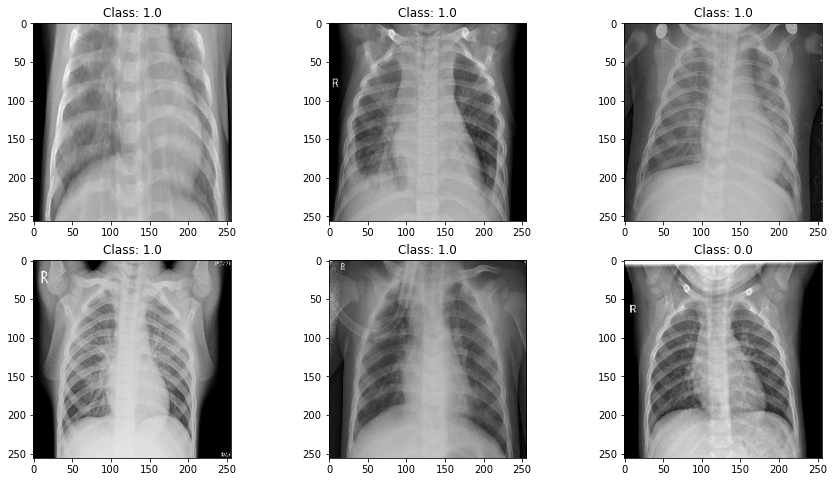

In [8]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {labels[0]}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {labels[1]}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {labels[2]}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {labels[3]}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {labels[4]}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {labels[5]}")

plt.show()

It seems images that arer very cloudy in the chest are Pneumonia while normal images are very clear. This means 1 is Pneumonia and 0 is Normal.

Image dimensions: (256, 256, 3)


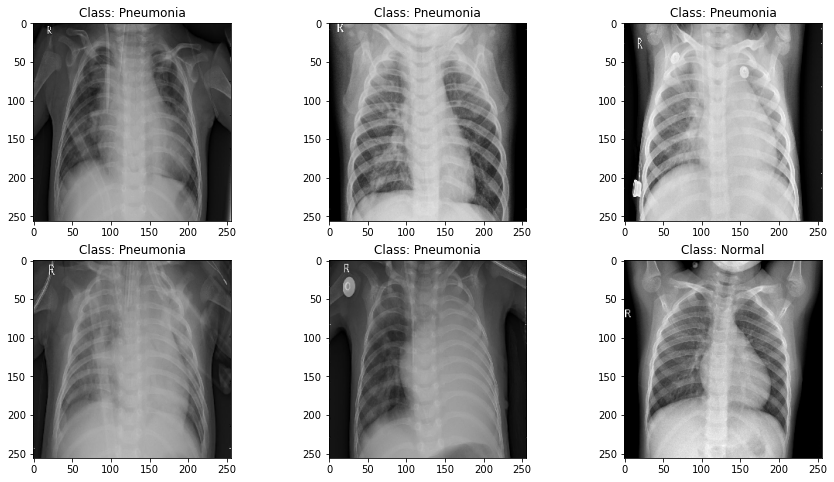

In [9]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {'Normal' if labels[0] == 0 else 'Pneumonia'}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {'Normal' if labels[1] == 0 else 'Pneumonia'}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {'Normal' if labels[2] == 0 else 'Pneumonia'}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {'Normal' if labels[3] == 0 else 'Pneumonia'}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {'Normal' if labels[4] == 0 else 'Pneumonia'}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {'Normal' if labels[5] == 0 else 'Pneumonia'}")

plt.show()


We sucecssfully resized the images and also created an RGB tensor. Lets create our datasets

# Make an Multilayer Perceptrons Model

I don't expect great perfomance in comparison to a Convuluted Neural Network. For the sake of trying we should attempt a basic neural network before getting more complex using basic MLP layers

**Base MLP Model:**

Define Base Model

We can attempt to train the model by iterating over the numebr of epochs. We can then save look at the validation and training loss and see where it begins to overfit.

In [10]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log
METRICS = metrics=[
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]

In [10]:
import time
import pandas as pd
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam


# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base = Sequential()

# Define the layers 
model_mlp_base.add(Flatten(input_shape=input_shape))
model_mlp_base.add(Dense(64, activation='relu'))
model_mlp_base.add(Dense(1, activation='sigmoid'))
model_mlp_base.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                12582976  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 12,583,041
Trainable params: 12,583,041
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
from functions import train_model

mlp = {}
mlp['Version1'] = train_model(model_mlp_base, train_gen, val_gen, total_epochs=15)

Epoch 1/15
  1/158 [..............................] - ETA: 0s - loss: 0.5365 - precision: 0.7812 - recall: 1.0000 - accuracy: 0.7812WARNING:tensorflow:From c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
158/158 [==============================] - 41s 260ms/step - loss: 5.5835 - precision: 0.8967 - recall: 0.9014 - accuracy: 0.8478 - val_loss: 2.3692 - val_precision: 1.0000 - val_recall: 0.7800 - val_accuracy: 0.8900
Epoch 2/15
158/158 [==============================] - 40s 252ms/step - loss: 2.0568 - precision: 0.9384 - recall: 0.9376 - accuracy: 0.9068 - val_loss: 1.9741 - val_precision: 0.8115 - val_recall: 0.9900 - val_accuracy: 0.8800
Epoch 3/15
158/158 [==============================] - 39s 246ms/step - loss: 1.5263 - precision: 0.9527 - recall: 0.9527 - accur

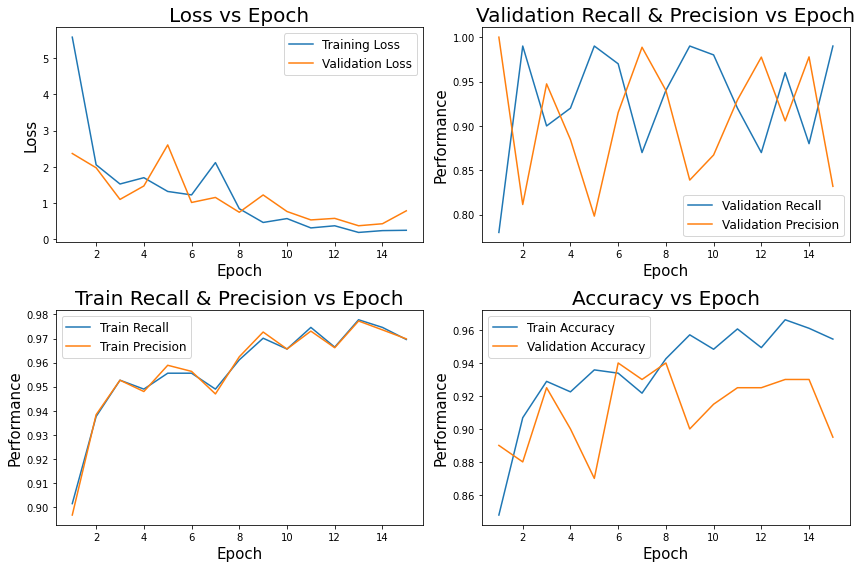

In [12]:
from functions import view_history

view_history(mlp, 'Version1')

In [13]:
from functions import model_evaluate

model_evaluate(model_mlp_base, train_gen, test_gen, val_gen)

7/7 [==============================] - 2s 223ms/step - loss: 0.7852 - precision: 0.8319 - recall: 0.9900 - accuracy: 0.8950


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.169925,96.222562,99.656355,96.800476
1,Test,2.923306,74.710423,99.230766,78.525639
2,Validation,0.785198,83.193278,99.000001,89.499998


This looks good. We generally follow closely with both curves. We can still add more neurons or add another layer to see if we are still generalizing well to capture more of the data. 

# MLP Version 2

In [14]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_2 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_2.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_2.add(Dense(64, activation='relu'))
model_mlp_base_2.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                12582976  
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 12,587,201
Trainable params: 12,587,201
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
from functions import train_model
# Update our dictionary with Version 2

mlp['Version2'] = train_model(model_mlp_base_2, train_gen, val_gen, total_epochs=15)

Epoch 1/15
158/158 [==============================] - 41s 259ms/step - loss: 1.8448 - precision: 0.8907 - recall: 0.8942 - accuracy: 0.8378 - val_loss: 0.1861 - val_precision: 0.8899 - val_recall: 0.9700 - val_accuracy: 0.9250
Epoch 2/15
158/158 [==============================] - 39s 245ms/step - loss: 0.3908 - precision: 0.9313 - recall: 0.9389 - accuracy: 0.9020 - val_loss: 0.1812 - val_precision: 0.9394 - val_recall: 0.9300 - val_accuracy: 0.9350
Epoch 3/15
158/158 [==============================] - 39s 245ms/step - loss: 0.1892 - precision: 0.9581 - recall: 0.9601 - accuracy: 0.9384 - val_loss: 0.4710 - val_precision: 0.7795 - val_recall: 0.9900 - val_accuracy: 0.8550
Epoch 4/15
158/158 [==============================] - 38s 244ms/step - loss: 0.2060 - precision: 0.9521 - recall: 0.9572 - accuracy: 0.9316 - val_loss: 0.6069 - val_precision: 1.0000 - val_recall: 0.7200 - val_accuracy: 0.8600
Epoch 5/15
158/158 [==============================] - 39s 244ms/step - loss: 0.1868 - precis

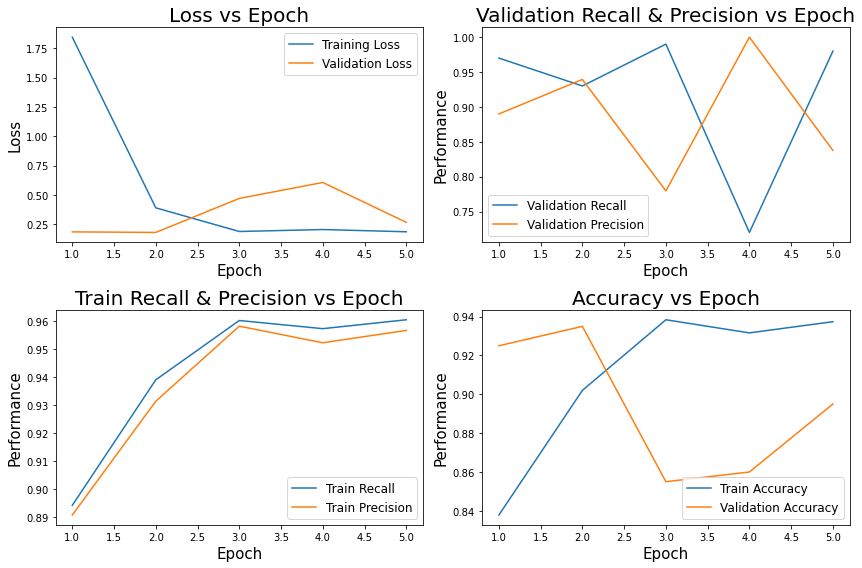

In [16]:
from functions import view_history
# Visualize the history 

view_history(mlp, 'Version2')

In [19]:
from functions import model_evaluate
# Evaluate the model

model_evaluate(model_mlp_base_2, train_gen, test_gen, val_gen)

7/7 [==============================] - 2s 216ms/step - loss: 0.4461 - precision: 0.9888 - recall: 0.8800 - accuracy: 0.9350


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.406071,98.744649,91.488236,92.726552
1,Test,0.771114,88.377726,93.589741,88.301283
2,Validation,0.446106,98.876405,88.000000,93.500000


It seems that adding another layer made the model overfit. We can see that because the loss curves diverged from eachother. One solution here would be to include regularization to see if we can address this

# MLP Version 3

In [17]:
from tensorflow.keras import Input, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_3 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_3.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_3.add(Dense(64, activation='relu'))
model_mlp_base_3.add(Dense(64, activation='relu', kernel_regularizer='l2'))
# Define output layer
model_mlp_base_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_3.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                12582976  
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 12,587,201
Trainable params: 12,587,201
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
# Update our dictionary with Version 3
mlp['Version3'] = train_model(model_mlp_base_3, train_gen, val_gen, total_epochs=30)

Epoch 1/30
158/158 [==============================] - 40s 255ms/step - loss: 2.1798 - precision: 0.8425 - recall: 0.8681 - accuracy: 0.7772 - val_loss: 0.5300 - val_precision: 0.8000 - val_recall: 0.9600 - val_accuracy: 0.8600
Epoch 2/30
158/158 [==============================] - 38s 242ms/step - loss: 0.3869 - precision: 0.9470 - recall: 0.9588 - accuracy: 0.9287 - val_loss: 0.3629 - val_precision: 0.9778 - val_recall: 0.8800 - val_accuracy: 0.9300
Epoch 3/30
158/158 [==============================] - 38s 242ms/step - loss: 0.3432 - precision: 0.9542 - recall: 0.9635 - accuracy: 0.9378 - val_loss: 0.3401 - val_precision: 0.9286 - val_recall: 0.9100 - val_accuracy: 0.9200
Epoch 4/30
158/158 [==============================] - 38s 243ms/step - loss: 0.3260 - precision: 0.9580 - recall: 0.9646 - accuracy: 0.9416 - val_loss: 0.3246 - val_precision: 0.9570 - val_recall: 0.8900 - val_accuracy: 0.9250
Epoch 5/30
158/158 [==============================] - 38s 240ms/step - loss: 0.3087 - precis

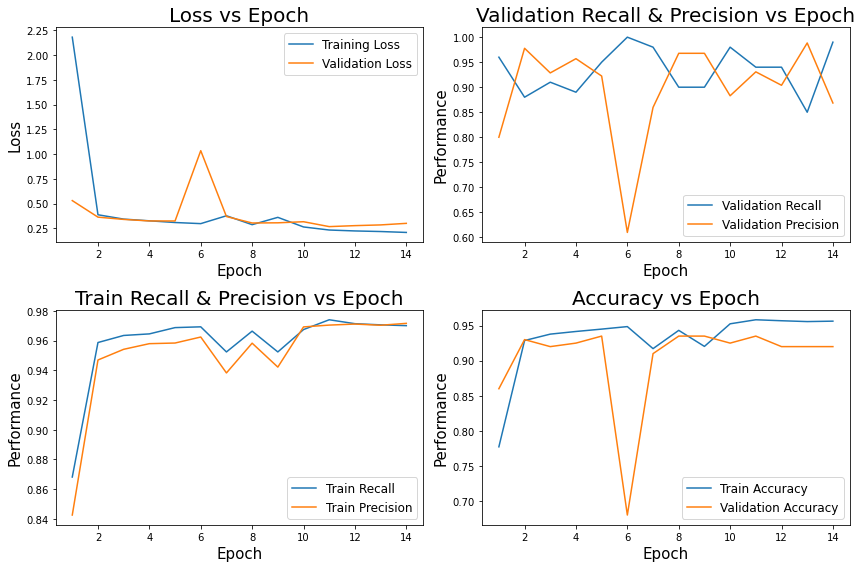

In [21]:
# Visualize the history 
from functions import view_history
view_history(mlp, 'Version3')

In [20]:
# Evaluate the model
from functions import model_evaluate
model_evaluate(model_mlp_base_3, train_gen, test_gen, val_gen)

7/7 [==============================] - 1s 207ms/step - loss: 0.3003 - precision: 0.8684 - recall: 0.9900 - accuracy: 0.9200


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.176271,97.119129,98.916203,96.979332
1,Test,0.823102,76.846308,98.717946,80.608976
2,Validation,0.300283,86.842108,99.000001,92.000002


This is interesting, there was a moment when our loss curves divereged at around epoch 5. The curves soon after returned back to closely following eachother. We can see that our train loss and validation loss decreased from .4 and .4 to .17 and .3 respectively. We do address the overfit from our seconf version MLP but now it seems we lost quite a buit of information. Lets add another layer to see if this will affect our train and val loss overall and maybe lower our test loss.

# MLP Version 4

In [22]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_4 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_4.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_4.add(Dense(64, activation='relu'))
model_mlp_base_4.add(Dense(64, activation='relu'))
model_mlp_base_4.add(Dense(64, activation='relu', kernel_regularizer='l2'))

# Define output layer
model_mlp_base_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_4.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                12582976  
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 12,591,361
Trainable params: 12,591,361
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# Update our dictionary with Version 4
mlp['Version4'] = train_model(model_mlp_base_4, train_gen, val_gen, total_epochs=15)

Epoch 1/15
158/158 [==============================] - 40s 256ms/step - loss: 3.3075 - precision: 0.8703 - recall: 0.8931 - accuracy: 0.8180 - val_loss: 0.5019 - val_precision: 0.9468 - val_recall: 0.8900 - val_accuracy: 0.9200
Epoch 2/15
158/158 [==============================] - 38s 241ms/step - loss: 0.5547 - precision: 0.9288 - recall: 0.9381 - accuracy: 0.8994 - val_loss: 0.5174 - val_precision: 0.8390 - val_recall: 0.9900 - val_accuracy: 0.9000
Epoch 3/15
158/158 [==============================] - 38s 240ms/step - loss: 0.4143 - precision: 0.9574 - recall: 0.9633 - accuracy: 0.9402 - val_loss: 0.4445 - val_precision: 0.8818 - val_recall: 0.9700 - val_accuracy: 0.9200
Epoch 4/15
158/158 [==============================] - 38s 239ms/step - loss: 0.4209 - precision: 0.9565 - recall: 0.9582 - accuracy: 0.9358 - val_loss: 0.6463 - val_precision: 0.7615 - val_recall: 0.9900 - val_accuracy: 0.8400
Epoch 5/15
158/158 [==============================] - 38s 239ms/step - loss: 0.3804 - precis

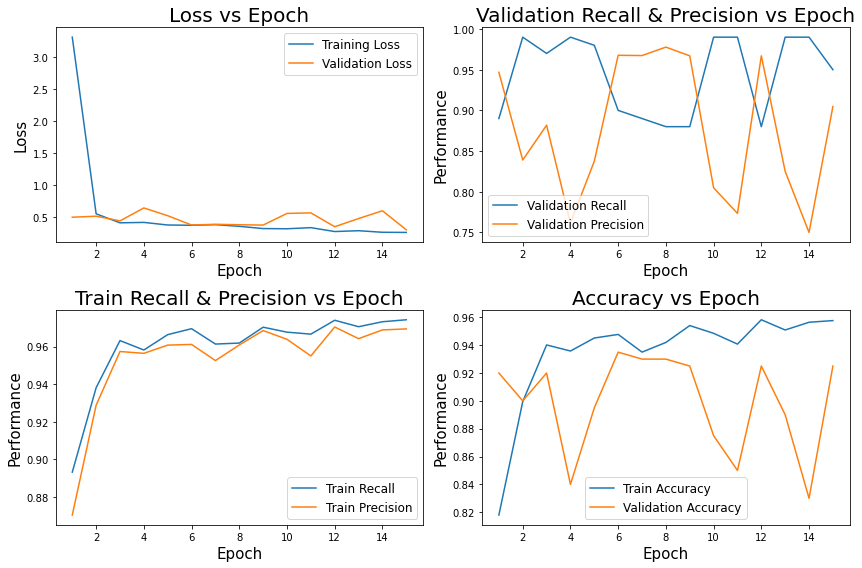

In [24]:
# Visualize the history 
from functions import view_history
view_history(mlp, 'Version4')

In [25]:
# Evaluate the model
from functions import model_evaluate
model_evaluate(model_mlp_base_4, train_gen, test_gen, val_gen)

7/7 [==============================] - 2s 217ms/step - loss: 0.3053 - precision: 0.9048 - recall: 0.9500 - accuracy: 0.9250


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.216967,98.435426,98.123181,97.416532
1,Test,0.726080,80.375785,98.717946,84.134614
2,Validation,0.305269,90.476191,94.999999,92.500001


It seems our intuition was correct in adding a layer. It seem we havent overfitted yet as our loss curves still follow eachother. Lets add anotehr layer to genralize better

# MLP Version 5

In [26]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_5 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_5.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_5.add(Dense(64, activation='relu'))
model_mlp_base_5.add(Dense(64, activation='relu'))
model_mlp_base_5.add(Dense(64, activation='relu'))
model_mlp_base_5.add(Dense(64, activation='relu', kernel_regularizer='l2'))

# Define output layer
model_mlp_base_5.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_5.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                12582976  
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 12,595,521
Trainable params: 12,595,521
Non-trainable params: 0
__________________________________________

In [27]:
mlp['Version5'] = train_model(model_mlp_base_5, train_gen, val_gen, total_epochs=15)

Epoch 1/15
158/158 [==============================] - 41s 258ms/step - loss: 1.2696 - precision: 0.8577 - recall: 0.8645 - accuracy: 0.7878 - val_loss: 2.5752 - val_precision: 0.5025 - val_recall: 1.0000 - val_accuracy: 0.5050
Epoch 2/15
158/158 [==============================] - 38s 243ms/step - loss: 0.5484 - precision: 0.9339 - recall: 0.9450 - accuracy: 0.9084 - val_loss: 0.5083 - val_precision: 1.0000 - val_recall: 0.8600 - val_accuracy: 0.9300
Epoch 3/15
158/158 [==============================] - 38s 240ms/step - loss: 0.4450 - precision: 0.9510 - recall: 0.9598 - accuracy: 0.9326 - val_loss: 0.5066 - val_precision: 0.9880 - val_recall: 0.8200 - val_accuracy: 0.9050
Epoch 4/15
158/158 [==============================] - 38s 239ms/step - loss: 0.4067 - precision: 0.9577 - recall: 0.9630 - accuracy: 0.9402 - val_loss: 0.4047 - val_precision: 0.9684 - val_recall: 0.9200 - val_accuracy: 0.9450
Epoch 5/15
158/158 [==============================] - 38s 240ms/step - loss: 0.3682 - precis

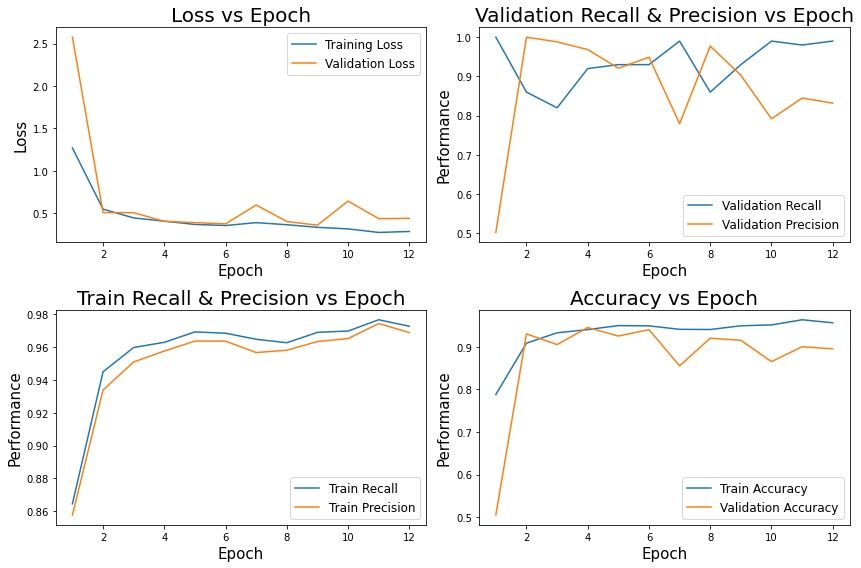

In [28]:
view_history(mlp, "Version5")

In [29]:
model_evaluate(model_mlp_base_5, train_gen, test_gen, val_gen)

7/7 [==============================] - 1s 201ms/step - loss: 0.4409 - precision: 0.8319 - recall: 0.9900 - accuracy: 0.8950


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.272293,95.599085,99.339151,96.065181
1,Test,1.049632,74.280232,99.230766,78.044873
2,Validation,0.440925,83.193278,99.000001,89.499998


Now it seems that we are starting to overfit slightly. Lets adjust our regualrization strength

# MLP Version 6

In [31]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_6 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_6.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_6.add(Dense(64, activation='relu'))
model_mlp_base_6.add(Dense(64, activation='relu'))
model_mlp_base_6.add(Dense(64, activation='relu'))
model_mlp_base_6.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1))) #default value apparently when using l2 as 'l2' is 0.01

# Define output layer
model_mlp_base_6.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_6.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                12582976  
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 12,595,521
Trainable params: 12,595,521
Non-trainable params: 0
__________________________________________

In [32]:
mlp['Version6'] = train_model(model_mlp_base_6, train_gen, val_gen, total_epochs=15)

Epoch 1/15
158/158 [==============================] - 41s 261ms/step - loss: 5.3904 - precision: 0.8740 - recall: 0.8893 - accuracy: 0.8198 - val_loss: 3.0583 - val_precision: 1.0000 - val_recall: 0.7900 - val_accuracy: 0.8950
Epoch 2/15
158/158 [==============================] - 39s 245ms/step - loss: 2.6367 - precision: 0.9361 - recall: 0.9490 - accuracy: 0.9130 - val_loss: 2.4747 - val_precision: 0.8083 - val_recall: 0.9700 - val_accuracy: 0.8700
Epoch 3/15
158/158 [==============================] - 38s 241ms/step - loss: 2.1563 - precision: 0.9464 - recall: 0.9522 - accuracy: 0.9235 - val_loss: 2.0913 - val_precision: 0.8305 - val_recall: 0.9800 - val_accuracy: 0.8900
Epoch 4/15
158/158 [==============================] - 38s 243ms/step - loss: 1.8449 - precision: 0.9607 - recall: 0.9640 - accuracy: 0.9434 - val_loss: 1.7772 - val_precision: 0.8796 - val_recall: 0.9500 - val_accuracy: 0.9100
Epoch 5/15
158/158 [==============================] - 38s 240ms/step - loss: 1.7042 - precis

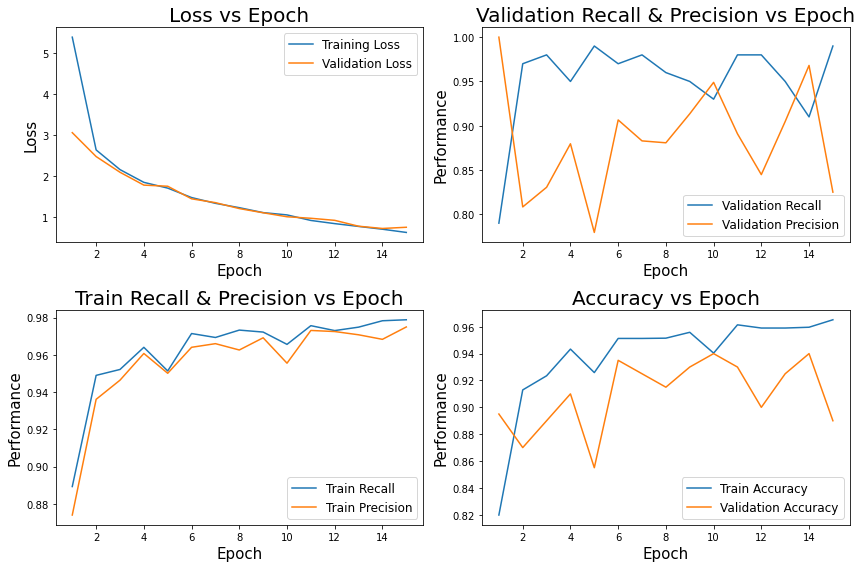

In [33]:
view_history(mlp, "Version6")

In [34]:
model_evaluate(model_mlp_base_6, train_gen, test_gen, val_gen)

7/7 [==============================] - 1s 207ms/step - loss: 0.7480 - precision: 0.8250 - recall: 0.9900 - accuracy: 0.8900


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.583692,96.358043,99.312717,96.661365
1,Test,1.332745,75.291830,99.230766,79.166669
2,Validation,0.748027,82.499999,99.000001,88.999999


It seems we are still overfitting since 

# MLP version 7

In [35]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_7 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_7.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_7.add(Dense(64, activation='relu'))
model_mlp_base_7.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_mlp_base_7.add(Dense(64, activation='relu'))
model_mlp_base_7.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1))) #default value apparently when using l2 as 'l2' is 0.01

# Define output layer
model_mlp_base_7.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_7.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_7.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                12582976  
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 12,595,521
Trainable params: 12,595,521
Non-trainable params: 0
__________________________________________

In [36]:
mlp['Version7'] = train_model(model_mlp_base_7, train_gen, val_gen, total_epochs=15)

Epoch 1/15
158/158 [==============================] - 42s 263ms/step - loss: 5.8245 - precision: 0.8730 - recall: 0.8869 - accuracy: 0.8176 - val_loss: 3.4250 - val_precision: 1.0000 - val_recall: 0.7900 - val_accuracy: 0.8950
Epoch 2/15
158/158 [==============================] - 39s 250ms/step - loss: 3.0555 - precision: 0.9232 - recall: 0.9347 - accuracy: 0.8925 - val_loss: 2.6882 - val_precision: 0.8305 - val_recall: 0.9800 - val_accuracy: 0.8900
Epoch 3/15
158/158 [==============================] - 39s 246ms/step - loss: 2.4739 - precision: 0.9542 - recall: 0.9580 - accuracy: 0.9338 - val_loss: 2.5320 - val_precision: 0.7857 - val_recall: 0.9900 - val_accuracy: 0.8600
Epoch 4/15
158/158 [==============================] - 39s 247ms/step - loss: 2.2831 - precision: 0.9358 - recall: 0.9448 - accuracy: 0.9098 - val_loss: 2.0703 - val_precision: 0.8972 - val_recall: 0.9600 - val_accuracy: 0.9250
Epoch 5/15
158/158 [==============================] - 38s 240ms/step - loss: 1.9330 - precis

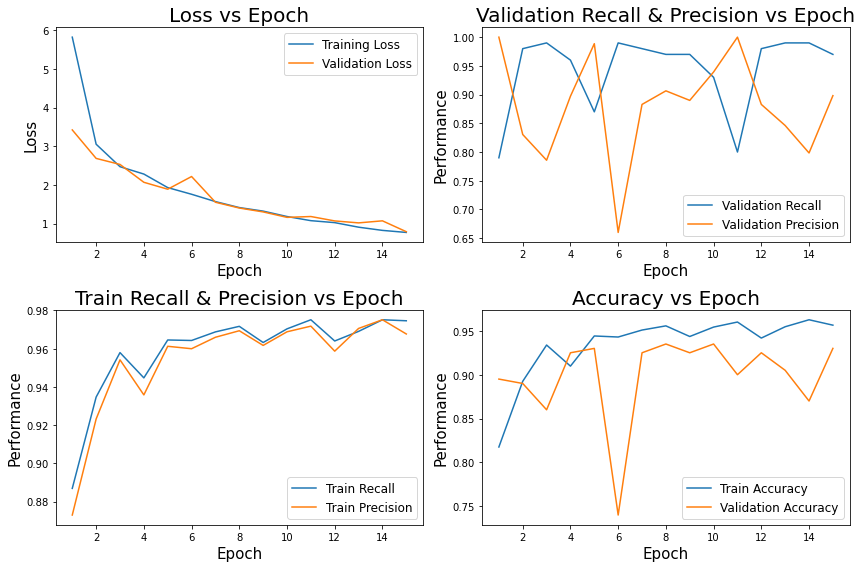

In [37]:
view_history(mlp, "Version7")

In [38]:
model_evaluate(model_mlp_base_7, train_gen, test_gen, val_gen)

7/7 [==============================] - 2s 227ms/step - loss: 0.7919 - precision: 0.8981 - recall: 0.9700 - accuracy: 0.9300


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.705052,98.069292,98.017448,97.058821
1,Test,1.240603,81.052631,98.717946,84.775639
2,Validation,0.791948,89.814812,97.000003,93.000001


# MLP Version 8

In [39]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_8 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_8.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_8.add(Dense(64, activation='relu'))
model_mlp_base_8.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_mlp_base_8.add(Dense(64, activation='relu'))
model_mlp_base_8.add(Dropout(0.2))
model_mlp_base_8.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1))) # default value apparently when using l2 as 'l2' is 0.01

# Define output layer
model_mlp_base_8.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_8.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_mlp_base_8.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                12582976  
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                

In [40]:
mlp['Version8'] = train_model(model_mlp_base_8, train_gen, val_gen, total_epochs=15)

Epoch 1/15
158/158 [==============================] - 41s 261ms/step - loss: 6.2870 - precision: 0.8432 - recall: 0.8421 - accuracy: 0.7601 - val_loss: 3.2149 - val_precision: 0.9773 - val_recall: 0.8600 - val_accuracy: 0.9200
Epoch 2/15
158/158 [==============================] - 41s 262ms/step - loss: 2.6904 - precision: 0.9253 - recall: 0.9463 - accuracy: 0.9022 - val_loss: 2.8951 - val_precision: 0.6135 - val_recall: 1.0000 - val_accuracy: 0.6850
Epoch 3/15
158/158 [==============================] - 39s 246ms/step - loss: 1.9927 - precision: 0.9342 - recall: 0.9638 - accuracy: 0.9217 - val_loss: 1.8901 - val_precision: 0.7734 - val_recall: 0.9900 - val_accuracy: 0.8500
Epoch 4/15
158/158 [==============================] - 39s 244ms/step - loss: 1.5785 - precision: 0.9463 - recall: 0.9643 - accuracy: 0.9320 - val_loss: 1.4229 - val_precision: 0.9143 - val_recall: 0.9600 - val_accuracy: 0.9350
Epoch 5/15
158/158 [==============================] - 39s 245ms/step - loss: 1.2787 - precis

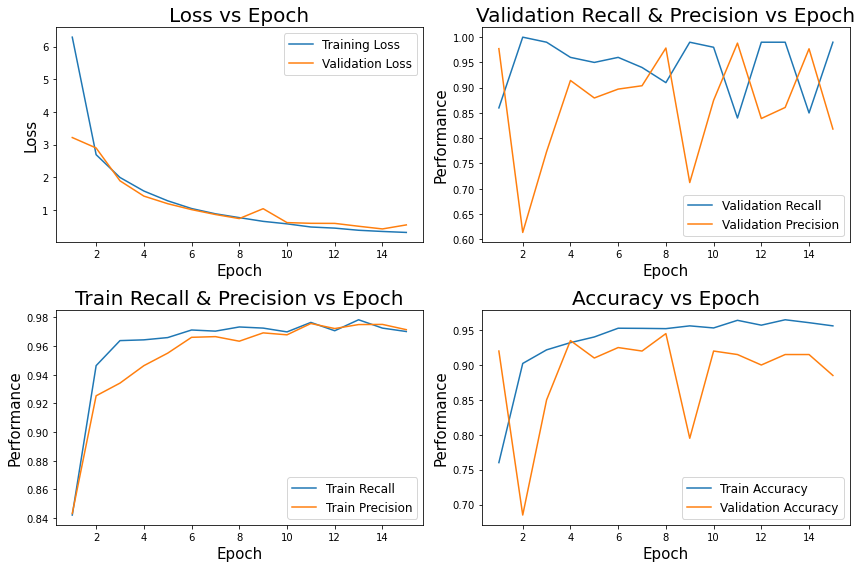

In [41]:
view_history(mlp, "Version8")

In [42]:
model_evaluate(model_mlp_base_8, train_gen, test_gen, val_gen)

7/7 [==============================] - 2s 216ms/step - loss: 0.5413 - precision: 0.8182 - recall: 0.9900 - accuracy: 0.8850


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.302355,95.601320,99.392015,96.104926
1,Test,1.285962,74.280232,99.230766,78.044873
2,Validation,0.541254,81.818181,99.000001,88.499999


Version 6 seems to be our best MLP model because it does not underfit like the models after it. We can see how the losses are very close to one another while in other models we have val loss below the train loss teh majority of the time. It seems its time to upgrade our model to Convolutinal neural Network to see if we can imporve our metrics

# Convolutional Neural Network


Based off our work from the MLP section Version 6 was our best model performance for loss and not overfitting. Lets use that layout and add Convolutional Layers to it

In [43]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_1 = Sequential()

# Define the layers
# Define our Conv layer
cnn_1.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=input_shape))
cnn_1.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_1.add(Flatten())

# Define our Dense Layers
cnn_1.add(Dense(64, activation='relu'))
cnn_1.add(Dense(64, activation='relu'))
cnn_1.add(Dense(64, activation='relu'))
cnn_1.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_1.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_1.summary())


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 258064)            0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                16516160  
_________________________________________________________________
dense_33 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_35 (Dense)             (None, 64)               

In [44]:
from functions import train_model

cnn = {}

cnn['Version1'] = train_model(cnn_1, train_gen, val_gen, 15)

Epoch 1/15
158/158 [==============================] - 63s 400ms/step - loss: 3.9711 - precision: 0.8922 - recall: 0.9374 - accuracy: 0.8688 - val_loss: 2.1190 - val_precision: 0.9406 - val_recall: 0.9500 - val_accuracy: 0.9450
Epoch 2/15
158/158 [==============================] - 59s 376ms/step - loss: 1.6140 - precision: 0.9770 - recall: 0.9778 - accuracy: 0.9660 - val_loss: 1.3157 - val_precision: 0.9796 - val_recall: 0.9600 - val_accuracy: 0.9700
Epoch 3/15
158/158 [==============================] - 59s 375ms/step - loss: 1.0999 - precision: 0.9886 - recall: 0.9897 - accuracy: 0.9837 - val_loss: 0.9796 - val_precision: 0.9700 - val_recall: 0.9700 - val_accuracy: 0.9700
Epoch 4/15
158/158 [==============================] - 59s 375ms/step - loss: 0.8052 - precision: 0.9947 - recall: 0.9934 - accuracy: 0.9911 - val_loss: 0.7571 - val_precision: 0.9896 - val_recall: 0.9500 - val_accuracy: 0.9700
Epoch 5/15
158/158 [==============================] - 59s 375ms/step - loss: 0.6037 - precis

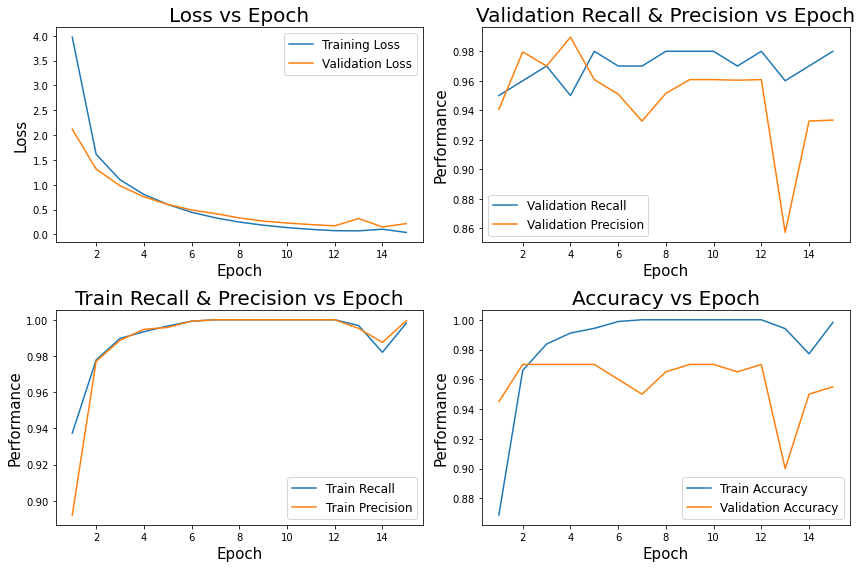

In [45]:
from functions import view_history

view_history(cnn, 'Version1')

In [46]:
from functions import model_evaluate

model_evaluate(cnn_1, train_gen, test_gen, val_gen)

7/7 [==============================] - 2s 226ms/step - loss: 0.2168 - precision: 0.9333 - recall: 0.9800 - accuracy: 0.9550


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.028363,99.973571,100.000000,99.980128
1,Test,1.628812,75.680935,99.743587,79.807693
2,Validation,0.216847,93.333334,98.000002,95.499998


We overfit 

# CNN Version 2

In [47]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_2 = Sequential()

# Define the layers
# Define our Conv layer
cnn_2.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=input_shape))
cnn_2.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_2.add(Flatten())

# Define our Dense Layers
cnn_2.add(Dense(64, activation='relu'))
cnn_2.add(Dense(64, activation='relu'))
cnn_2.add(Dense(64, activation='relu'))
cnn_2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_2.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_2.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 516128)            0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                33032256  
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_40 (Dense)             (None, 64)               

In [48]:
from functions import train_model

cnn['Version2'] = train_model(cnn_2, train_gen, val_gen, 15)

Epoch 1/15
158/158 [==============================] - 86s 546ms/step - loss: 3.3410 - precision: 0.9035 - recall: 0.9454 - accuracy: 0.8818 - val_loss: 1.4460 - val_precision: 0.9000 - val_recall: 0.9900 - val_accuracy: 0.9400
Epoch 2/15
158/158 [==============================] - 84s 531ms/step - loss: 0.8988 - precision: 0.9852 - recall: 0.9831 - accuracy: 0.9762 - val_loss: 0.6957 - val_precision: 0.9596 - val_recall: 0.9500 - val_accuracy: 0.9550
Epoch 3/15
158/158 [==============================] - 83s 523ms/step - loss: 0.5083 - precision: 0.9934 - recall: 0.9947 - accuracy: 0.9911 - val_loss: 0.5055 - val_precision: 0.9703 - val_recall: 0.9800 - val_accuracy: 0.9750
Epoch 4/15
158/158 [==============================] - 82s 519ms/step - loss: 0.3489 - precision: 0.9968 - recall: 0.9974 - accuracy: 0.9956 - val_loss: 0.4643 - val_precision: 0.9065 - val_recall: 0.9700 - val_accuracy: 0.9350
Epoch 5/15
158/158 [==============================] - 83s 526ms/step - loss: 0.2564 - precis

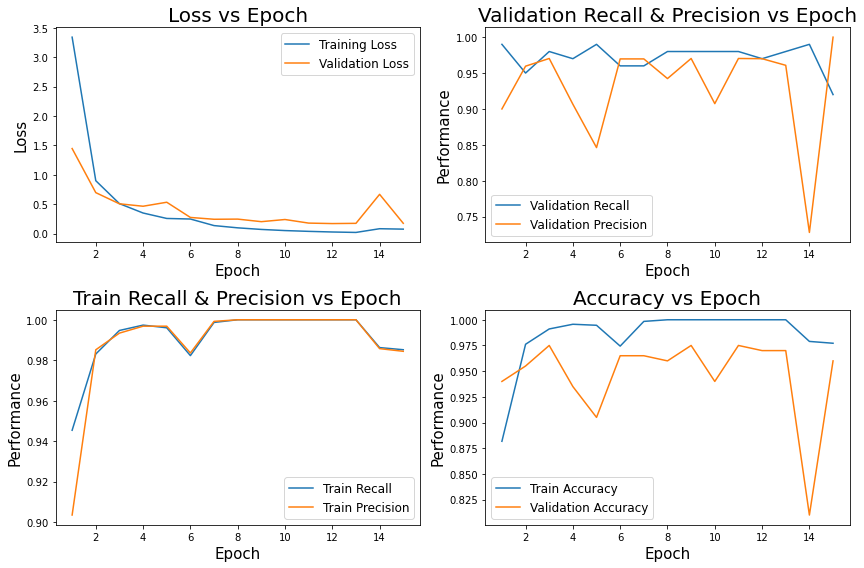

In [49]:
from functions import view_history

view_history(cnn, 'Version2')

In [50]:
from functions import model_evaluate

model_evaluate(cnn_2, train_gen, test_gen, val_gen)

7/7 [==============================] - 2s 249ms/step - loss: 0.1739 - precision: 1.0000 - recall: 0.9200 - accuracy: 0.9600


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.078432,100.00000,96.563572,97.416532
1,Test,0.360819,85.68182,96.666664,87.820512
2,Validation,0.173919,100.00000,92.000002,95.999998


Eventhough our train and validation did well our test has a big performance drop. It seems the model is overfitting 

# CNN Version 3

In [19]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_3 = Sequential()

# Define the layers
# Define our Conv layer
cnn_3.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=input_shape))
cnn_3.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_3.add(Flatten())

# Define our Dense Layers
cnn_3.add(Dense(64, activation='relu'))
cnn_3.add(Dropout(.2, seed=42))
cnn_3.add(Dense(64, activation='relu'))
cnn_3.add(Dropout(.2, seed=42))
cnn_3.add(Dense(64, activation='relu'))
cnn_3.add(Dropout(.2, seed=42))
cnn_3.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_3.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_3.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_3.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 516128)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                33032256  
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

Epoch 1/15
  1/158 [..............................] - ETA: 0s - loss: 6.9987 - precision: 0.7692 - recall: 0.4000 - accuracy: 0.4375WARNING:tensorflow:From c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
158/158 [==============================] - 81s 512ms/step - loss: 3.8776 - precision: 0.8208 - recall: 0.9371 - accuracy: 0.7989 - val_loss: 1.6887 - val_precision: 0.9300 - val_recall: 0.9300 - val_accuracy: 0.9300
Epoch 2/15
158/158 [==============================] - 80s 504ms/step - loss: 0.9183 - precision: 0.9749 - recall: 0.9654 - accuracy: 0.9553 - val_loss: 0.5041 - val_precision: 0.9510 - val_recall: 0.9700 - val_accuracy: 0.9600
Epoch 3/15
158/158 [==============================] - 80s 505ms/step - loss: 0.3080 - precision: 0.9835 - recall: 0.9783 - accur

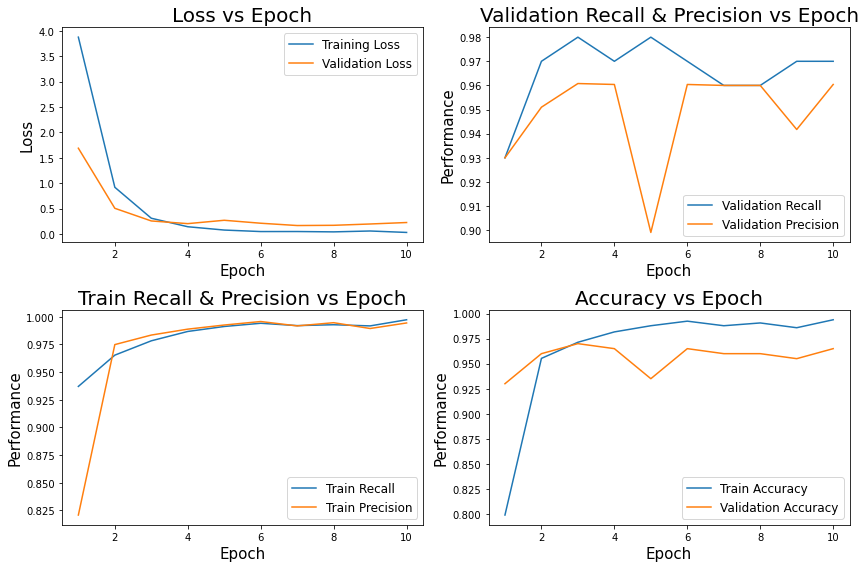

7/7 [==============================] - 2s 246ms/step - loss: 0.2238 - precision: 0.9604 - recall: 0.9700 - accuracy: 0.9650


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.017407,100.000000,99.629921,99.721783
1,Test,0.868863,80.497926,99.487180,84.615386
2,Validation,0.223805,96.039605,97.000003,96.499997


In [20]:
from functions import train_model, view_history, model_evaluate
cnn={}
# Train model
cnn['Version3'] = train_model(cnn_3, train_gen, val_gen, 15)

# Display history 
view_history(cnn, 'Version3')

# Evaluate Model
model_evaluate(cnn_3, train_gen, test_gen, val_gen)

Our test loss significantly increased. Perhaps the answer is that we are actually underfitting. Our valuidation loss is always below our train loss. Lets increase the filters to 64 and remove the dropout and keep the layeout as in version 2

# CNN Version 4


In [12]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_4 = Sequential()

# Define the layers
# Define our Conv layer
cnn_4.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=input_shape))
cnn_4.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_4.add(Flatten())

# Define our Dense Layers
cnn_4.add(Dense(64, activation='relu'))
cnn_4.add(Dense(64, activation='relu'))
cnn_4.add(Dense(64, activation='relu'))
cnn_4.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_4.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_4.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_4.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1032256)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                66064448  
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

Epoch 1/15
  1/158 [..............................] - ETA: 0s - loss: 7.0232 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.2188WARNING:tensorflow:From c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
158/158 [==============================] - 135s 853ms/step - loss: 3.4600 - precision: 0.8945 - recall: 0.9506 - accuracy: 0.8786 - val_loss: 1.5575 - val_precision: 0.9417 - val_recall: 0.9700 - val_accuracy: 0.9550
Epoch 2/15
158/158 [==============================] - 132s 838ms/step - loss: 1.0251 - precision: 0.9820 - recall: 0.9791 - accuracy: 0.9708 - val_loss: 0.8040 - val_precision: 0.9333 - val_recall: 0.9800 - val_accuracy: 0.9550
Epoch 3/15
158/158 [==============================] - 134s 848ms/step - loss: 0.5615 - precision: 0.9950 - recall: 0.9

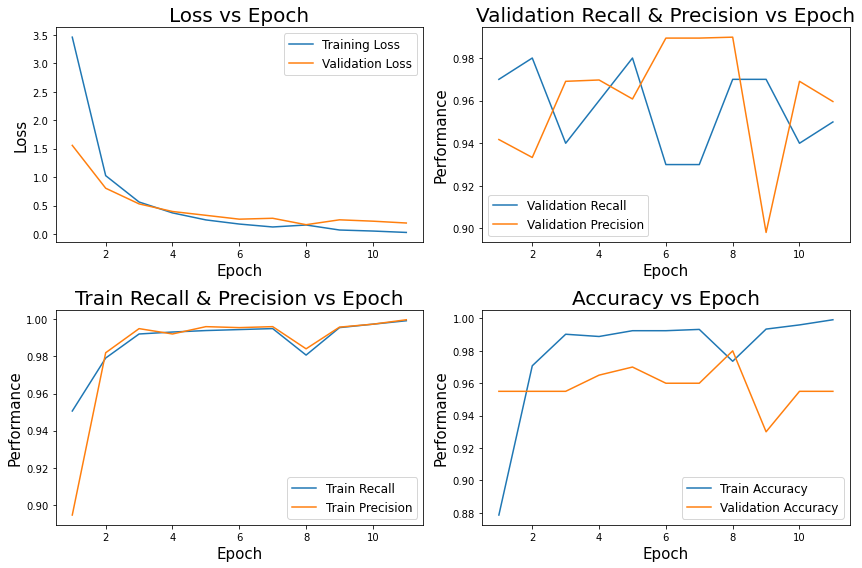

7/7 [==============================] - 2s 295ms/step - loss: 0.1628 - precision: 0.9898 - recall: 0.9700 - accuracy: 0.9800


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.075908,99.946994,99.682790,99.721783
1,Test,0.660900,78.585857,99.743587,82.852566
2,Validation,0.162767,98.979592,97.000003,98.000002


In [14]:
from functions import view_history, model_evaluate, train_model
# Train model
cnn = {}

cnn['Version4'] = train_model(cnn_4, train_gen, val_gen, 15)

# Display history 
view_history(cnn, 'Version4')

# Evaluate Model
model_evaluate(cnn_4, train_gen, test_gen, val_gen)

This model did overft. Both losses diverged from eachother. Lets restart from version 1 since it seems we have overfitting all the time. 

# CNN Version 5 

In [15]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_5 = Sequential()

# Define the layers
# Define our Conv layer
cnn_5.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=input_shape))
cnn_5.add(MaxPool2D())
cnn_5.add(Conv2D(32, (3,3), 1, activation='relu'))
cnn_5.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_5.add(Flatten())

# Define our Dense Layers
cnn_5.add(Dense(64, activation='relu'))
cnn_5.add(Dense(64, activation='relu'))
cnn_5.add(Dense(64, activation='relu'))
cnn_5.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
cnn_5.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_5.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_5.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 516128)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               66064512  
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 64)               

Epoch 1/40
123/123 [==============================] - 117s 948ms/step - loss: 0.7081 - precision: 0.9110 - recall: 0.9145 - accuracy: 0.8452 - val_loss: 0.0786 - val_precision: 0.9991 - val_recall: 0.9725 - val_accuracy: 0.9746
Epoch 2/40
123/123 [==============================] - 98s 800ms/step - loss: 0.0788 - precision: 0.9805 - recall: 0.9779 - accuracy: 0.9713 - val_loss: 0.2506 - val_precision: 0.9991 - val_recall: 0.9055 - val_accuracy: 0.9145
Epoch 3/40
123/123 [==============================] - 98s 800ms/step - loss: 0.0426 - precision: 0.9930 - recall: 0.9901 - accuracy: 0.9883 - val_loss: 0.1446 - val_precision: 1.0000 - val_recall: 0.9364 - val_accuracy: 0.9430
Epoch 4/40
123/123 [==============================] - 98s 800ms/step - loss: 0.0368 - precision: 0.9937 - recall: 0.9901 - accuracy: 0.9888 - val_loss: 0.1043 - val_precision: 0.9939 - val_recall: 0.9751 - val_accuracy: 0.9723
Epoch 5/40
123/123 [==============================] - 98s 801ms/step - loss: 0.0283 - preci

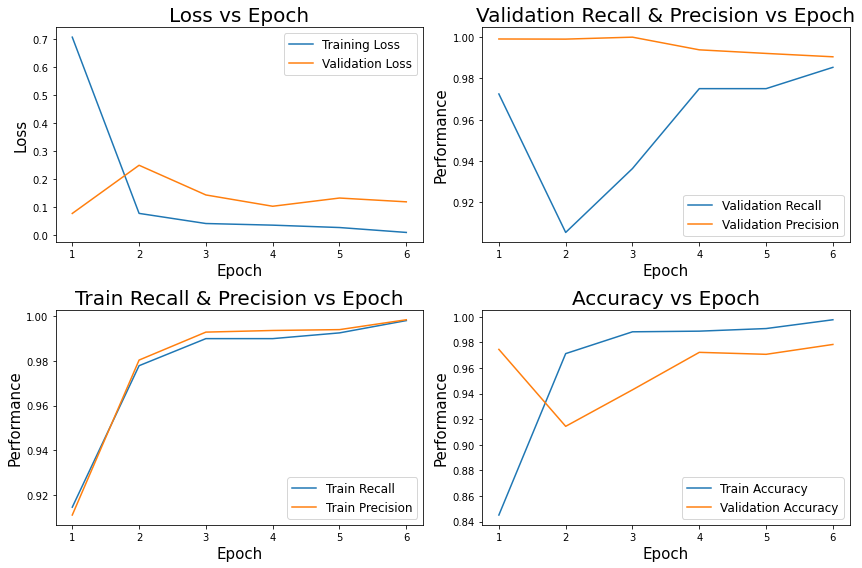

The model is not overfitting in terms of loss.
41/41 [==============================] - 15s 362ms/step - loss: 0.1200 - precision: 0.9905 - recall: 0.9854 - accuracy: 0.9784


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.002349,99.963236,100.000000,99.974579
1,Test,1.488569,77.335984,99.743587,81.570512
2,Validation,0.120039,99.050087,98.539519,97.842836


In [16]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version5'] = train_model(cnn_5, train_gen, val_gen, 15)

# Display history 
view_history(cnn, 'Version5')

# Evaluate Model
model_evaluate(cnn_5, train_gen, test_gen, val_gen)

# CNN Version 6

In [17]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_6 = Sequential()

# Define the layers
# Define our Conv layer
cnn_6.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=input_shape))
cnn_6.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=input_shape))
cnn_6.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_6.add(Flatten())

# Define our Dense Layers
cnn_6.add(Dense(128, activation='relu'))
cnn_6.add(Dense(128, activation='relu'))
cnn_6.add(Dense(64, activation='relu'))
cnn_6.add(Dense(64, activation='relu'))
cnn_6.add(Dropout(.3))

# Define output layer
cnn_6.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_6.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_6.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 508032)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               65028224  
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 64)               

Epoch 1/40
123/123 [==============================] - 163s 1s/step - loss: 0.2976 - precision: 0.9274 - recall: 0.9310 - accuracy: 0.8671 - val_loss: 0.2810 - val_precision: 0.9980 - val_recall: 0.8608 - val_accuracy: 0.8737
Epoch 2/40
123/123 [==============================] - 158s 1s/step - loss: 0.1352 - precision: 0.9678 - recall: 0.9603 - accuracy: 0.9504 - val_loss: 0.1027 - val_precision: 0.9869 - val_recall: 0.9734 - val_accuracy: 0.9646
Epoch 3/40
123/123 [==============================] - 159s 1s/step - loss: 0.0770 - precision: 0.9801 - recall: 0.9805 - accuracy: 0.9728 - val_loss: 0.1402 - val_precision: 0.9938 - val_recall: 0.9631 - val_accuracy: 0.9615
Epoch 4/40
123/123 [==============================] - 159s 1s/step - loss: 0.0757 - precision: 0.9882 - recall: 0.9853 - accuracy: 0.9817 - val_loss: 0.0833 - val_precision: 0.9913 - val_recall: 0.9828 - val_accuracy: 0.9769
Epoch 5/40
123/123 [==============================] - 158s 1s/step - loss: 0.0231 - precision: 0.994

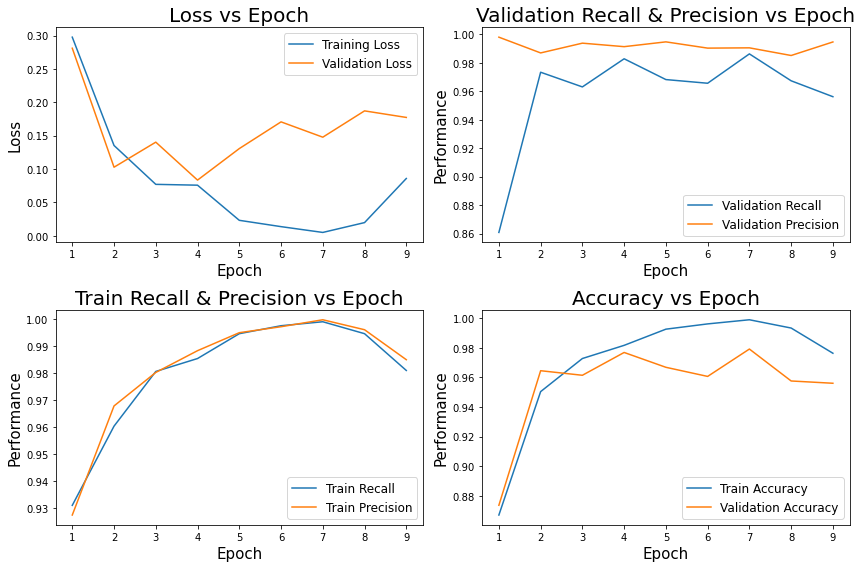

The model is not overfitting in terms of loss.
41/41 [==============================] - 17s 412ms/step - loss: 0.1773 - precision: 0.9946 - recall: 0.9562 - accuracy: 0.9561


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.008379,100.000000,99.485105,99.644130
1,Test,1.064725,79.664570,97.435898,82.852566
2,Validation,0.177271,99.463809,95.618558,95.608628


In [18]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version6'] = train_model(cnn_6, train_gen, val_gen, 40)

# Display history 
view_history(cnn, 'Version6')

# Check overfit
check_overfitting(cnn, 'Version6')

# Evaluate Model
model_evaluate(cnn_6, train_gen, test_gen, val_gen)

We overfitted again so maybe what is causing overfitting is the number of filters used so lets use only 8

In [19]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_7 = Sequential()

# Define the layers
# Define our Conv layer
cnn_7.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=input_shape))
cnn_7.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_7.add(Flatten())

# Define our Dense Layers
cnn_7.add(Dense(128, activation='relu'))
cnn_7.add(Dense(128, activation='relu'))
cnn_7.add(Dense(64, activation='relu'))
cnn_7.add(Dense(64, activation='relu'))
cnn_7.add(Dropout(.2))

# Define output layer
cnn_7.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_7.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_7.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 258064)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               33032320  
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_24 (Dense)             (None, 64)               

Epoch 1/40
123/123 [==============================] - 83s 672ms/step - loss: 0.4920 - precision: 0.9001 - recall: 0.9142 - accuracy: 0.8297 - val_loss: 0.2984 - val_precision: 0.9980 - val_recall: 0.8608 - val_accuracy: 0.8737
Epoch 2/40
123/123 [==============================] - 81s 657ms/step - loss: 0.1150 - precision: 0.9708 - recall: 0.9676 - accuracy: 0.9575 - val_loss: 0.0926 - val_precision: 0.9956 - val_recall: 0.9785 - val_accuracy: 0.9769
Epoch 3/40
123/123 [==============================] - 80s 650ms/step - loss: 0.0823 - precision: 0.9815 - recall: 0.9761 - accuracy: 0.9708 - val_loss: 0.0649 - val_precision: 0.9905 - val_recall: 0.9905 - val_accuracy: 0.9831
Epoch 4/40
123/123 [==============================] - 80s 653ms/step - loss: 0.0237 - precision: 0.9945 - recall: 0.9926 - accuracy: 0.9911 - val_loss: 0.0737 - val_precision: 0.9905 - val_recall: 0.9820 - val_accuracy: 0.9753
Epoch 5/40
123/123 [==============================] - 81s 656ms/step - loss: 0.0177 - precis

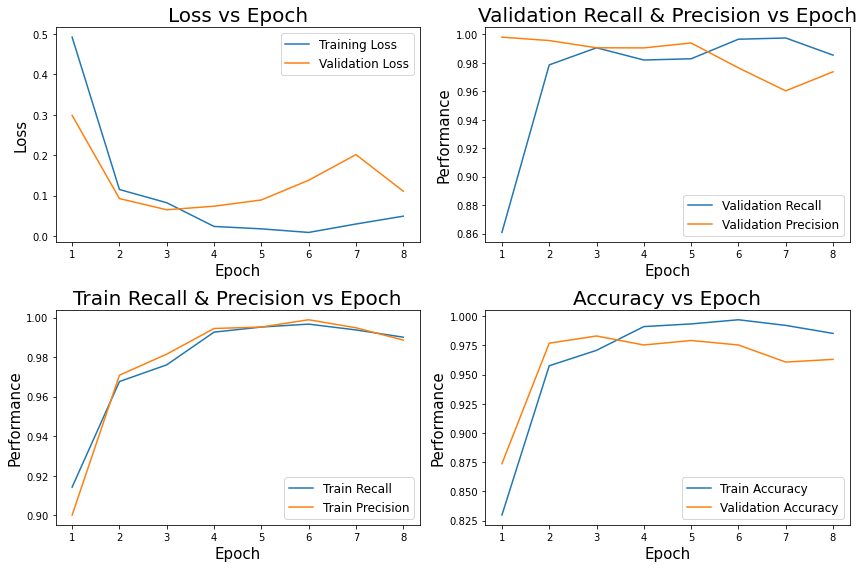

The model is not overfitting in terms of loss.
41/41 [==============================] - 13s 321ms/step - loss: 0.1109 - precision: 0.9737 - recall: 0.9854 - accuracy: 0.9630


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.060196,97.003210,100.000000,97.864771
1,Test,1.232728,72.897196,100.000000,76.762819
2,Validation,0.110852,97.368419,98.539519,96.302003


In [20]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version7'] = train_model(cnn_7, train_gen, val_gen, 40)

# Display history 
view_history(cnn, 'Version7')

# Check overfit
check_overfitting(cnn, 'Version7')

# Evaluate Model
model_evaluate(cnn_7, train_gen, test_gen, val_gen)

In [21]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_8 = Sequential()

# Define the layers
# Define our Conv layer
cnn_8.add(Conv2D(8, (3,3), 1, activation='relu', input_shape=input_shape))
cnn_8.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_8.add(Flatten())

# Define our Dense Layers
cnn_8.add(Dense(128, activation='relu'))
cnn_8.add(Dense(128, activation='relu'))
cnn_8.add(Dense(64, activation='relu'))
cnn_8.add(Dense(64, activation='relu'))
cnn_8.add(Dropout(.2))

# Define output layer
cnn_8.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_8.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_8.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 8)       224       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 8)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 129032)            0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16516224  
_________________________________________________________________
dense_27 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_29 (Dense)             (None, 64)               

Epoch 1/40
123/123 [==============================] - 74s 601ms/step - loss: 0.5314 - precision: 0.9006 - recall: 0.9150 - accuracy: 0.8287 - val_loss: 0.1999 - val_precision: 0.9991 - val_recall: 0.9072 - val_accuracy: 0.9160
Epoch 2/40
123/123 [==============================] - 72s 584ms/step - loss: 0.1368 - precision: 0.9661 - recall: 0.9647 - accuracy: 0.9522 - val_loss: 0.0624 - val_precision: 0.9956 - val_recall: 0.9794 - val_accuracy: 0.9777
Epoch 3/40
123/123 [==============================] - 72s 584ms/step - loss: 0.0693 - precision: 0.9856 - recall: 0.9809 - accuracy: 0.9769 - val_loss: 0.0527 - val_precision: 0.9814 - val_recall: 0.9948 - val_accuracy: 0.9784
Epoch 4/40
123/123 [==============================] - 72s 584ms/step - loss: 0.0346 - precision: 0.9926 - recall: 0.9904 - accuracy: 0.9883 - val_loss: 0.0461 - val_precision: 0.9965 - val_recall: 0.9863 - val_accuracy: 0.9846
Epoch 5/40
123/123 [==============================] - 72s 585ms/step - loss: 0.0301 - precis

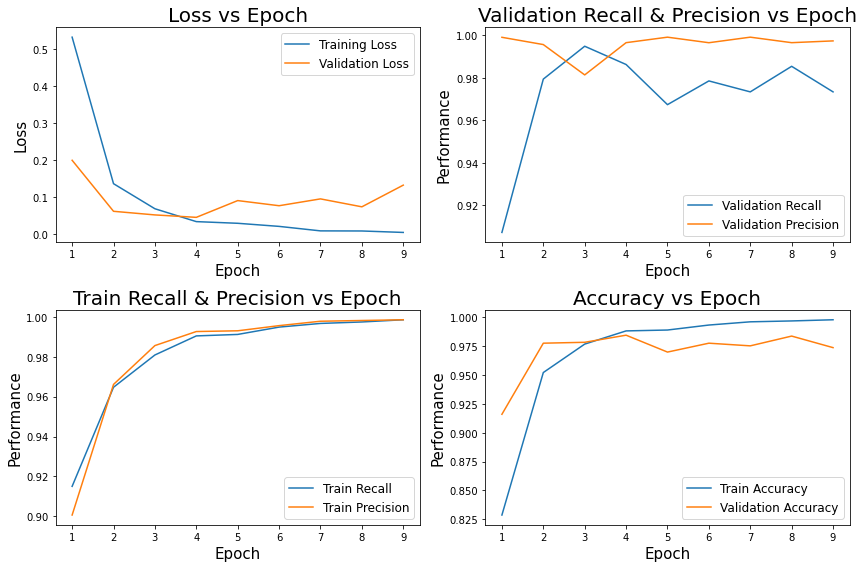

The model is not overfitting in terms of loss.
41/41 [==============================] - 14s 333ms/step - loss: 0.1329 - precision: 0.9974 - recall: 0.9734 - accuracy: 0.9738


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.001398,100.000000,99.963224,99.974579
1,Test,1.017068,82.340425,99.230766,86.217946
2,Validation,0.132881,99.735916,97.336769,97.380584


In [22]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version8'] = train_model(cnn_8, train_gen, val_gen, 40)

# Display history 
view_history(cnn, 'Version8')

# Check overfit
check_overfitting(cnn, 'Version8')

# Evaluate Model
model_evaluate(cnn_8, train_gen, test_gen, val_gen)

# CNN Version 9 

In [10]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_9 = Sequential()

# Define the layers
# Define our Conv layer
cnn_9.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=input_shape))
cnn_9.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_9.add(Flatten())

# Define our Dense Layers
cnn_9.add(Dense(128, activation='relu', kernel_regularizer=l2()))
cnn_9.add(Dense(128, activation='relu'))
cnn_9.add(Dense(64, activation='relu'))
cnn_9.add(Dense(64, activation='relu'))
cnn_9.add(Dropout(.2))

# Define output layer
cnn_9.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_9.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_9.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 516128)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               66064512  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4

Epoch 1/20
  1/123 [..............................] - ETA: 0s - loss: 3.2480 - precision: 0.5938 - recall: 1.0000 - accuracy: 0.5938WARNING:tensorflow:From c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
123/123 [==============================] - 103s 837ms/step - loss: 1.1666 - precision: 0.8202 - recall: 0.8941 - accuracy: 0.7913 - val_loss: 0.4985 - val_precision: 0.9970 - val_recall: 0.8686 - val_accuracy: 0.8798
Epoch 2/20
123/123 [==============================] - 102s 833ms/step - loss: 0.4700 - precision: 0.9404 - recall: 0.9338 - accuracy: 0.9133 - val_loss: 0.2836 - val_precision: 0.9921 - val_recall: 0.9665 - val_accuracy: 0.9630
Epoch 3/20
123/123 [==============================] - 101s 824ms/step - loss: 0.3766 - precision: 0.9661 - recall: 0.9533 - ac

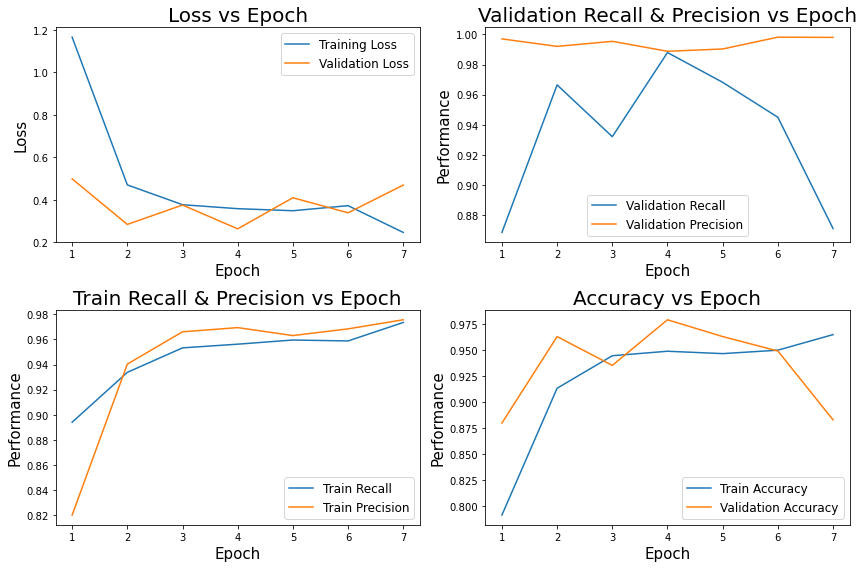

41/41 [==============================] - 11s 270ms/step - loss: 0.4692 - precision: 0.9980 - recall: 0.8711 - accuracy: 0.8829


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.364474,99.875879,88.782638,92.170817
1,Test,0.414907,93.264246,92.307693,91.025639
2,Validation,0.469191,99.803150,87.113404,88.289678


In [11]:
from functions import model_evaluate, train_model, view_history
cnn={}
# Train model
cnn['Version9'] = train_model(cnn_9, train_gen, val_gen, 20)

# Display history 
view_history(cnn, 'Version9')

# Evaluate Model
model_evaluate(cnn_9, train_gen, test_gen, val_gen)


It seems adding kernel regularization helped. Lets add a second another layer with regularization

# CNN Version 10

In [12]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_10 = Sequential()

# Define the layers
# Define our Conv layer
cnn_10.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=input_shape))
cnn_10.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_10.add(Flatten())

# Define our Dense Layers
cnn_10.add(Dense(128, activation='relu', kernel_regularizer=l2()))
cnn_10.add(Dense(128, activation='relu'))
cnn_10.add(Dense(64, activation='relu', kernel_regularizer=l2()))
cnn_10.add(Dense(64, activation='relu'))
cnn_10.add(Dropout(.2))

# Define output layer
cnn_10.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_10.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_10.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 516128)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               66064512  
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

Epoch 1/25
123/123 [==============================] - 104s 848ms/step - loss: 2.2205 - precision: 0.8844 - recall: 0.8823 - accuracy: 0.8086 - val_loss: 0.7420 - val_precision: 0.9780 - val_recall: 0.9923 - val_accuracy: 0.9730
Epoch 2/25
123/123 [==============================] - 102s 829ms/step - loss: 0.8104 - precision: 0.9389 - recall: 0.9489 - accuracy: 0.9220 - val_loss: 0.8539 - val_precision: 0.9990 - val_recall: 0.8660 - val_accuracy: 0.8790
Epoch 3/25
123/123 [==============================] - 102s 828ms/step - loss: 0.7200 - precision: 0.9559 - recall: 0.9481 - accuracy: 0.9339 - val_loss: 0.5863 - val_precision: 0.9965 - val_recall: 0.9811 - val_accuracy: 0.9800
Epoch 4/25
123/123 [==============================] - 103s 836ms/step - loss: 0.6530 - precision: 0.9610 - recall: 0.9526 - accuracy: 0.9405 - val_loss: 0.5599 - val_precision: 0.9854 - val_recall: 0.9863 - val_accuracy: 0.9746
Epoch 5/25
123/123 [==============================] - 102s 831ms/step - loss: 0.6698 - p

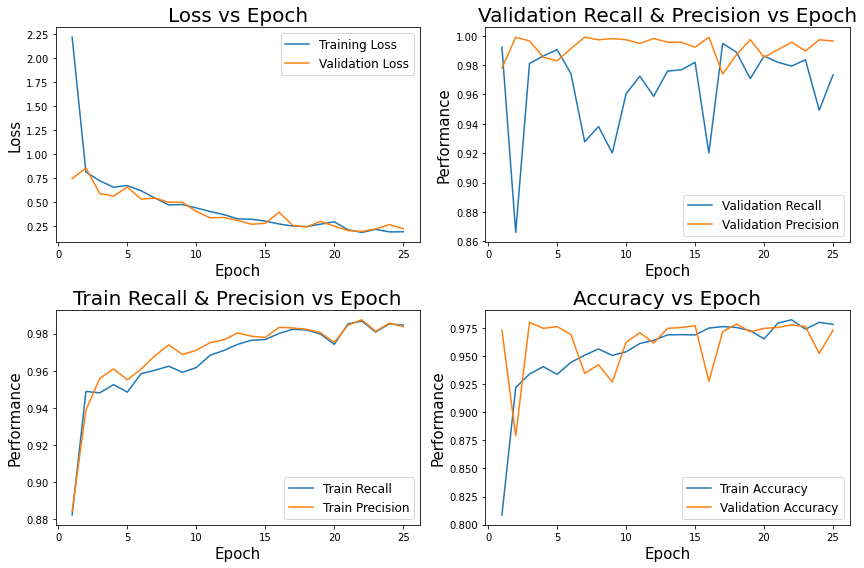

41/41 [==============================] - 11s 269ms/step - loss: 0.2192 - precision: 0.9965 - recall: 0.9734 - accuracy: 0.9730


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.160363,99.630040,99.043769,99.084902
1,Test,0.683281,82.403433,98.461539,85.897434
2,Validation,0.219229,99.648196,97.336769,97.303545


In [13]:
from functions import model_evaluate, train_model, view_history
cnn = {}
# Train model
cnn['Version10'] = train_model(cnn_10, train_gen, val_gen, 25)

# Display history 
view_history(cnn, 'Version10')

# Evaluate model
model_evaluate(cnn_10, train_gen, test_gen, val_gen)


We are doing better by adding more regularization. Our test loss is decreasing and so is our train and loss. We arent overfitting anymore but our test Precision is not that high. Lets add another Convolutional layer. 

# CNN Version 11

In [14]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_11 = Sequential()

# Define the layers
# Define our Conv layer
cnn_11.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=input_shape))
cnn_11.add(Conv2D(32, (3,3), 1, activation='relu'))
cnn_11.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_11.add(Flatten())

# Define our Dense Layers
cnn_11.add(Dense(128, activation='relu', kernel_regularizer=l2()))
cnn_11.add(Dense(128, activation='relu'))
cnn_11.add(Dense(64, activation='relu', kernel_regularizer=l2()))
cnn_11.add(Dense(64, activation='relu'))
cnn_11.add(Dropout(.2))

# Define output layer
cnn_11.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_11.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(cnn_11.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 508032)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65028224  
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

Epoch 1/20
123/123 [==============================] - 196s 2s/step - loss: 1.8013 - precision: 0.8859 - recall: 0.9297 - accuracy: 0.8213 - val_loss: 0.7384 - val_precision: 0.9730 - val_recall: 0.9905 - val_accuracy: 0.9669
Epoch 2/20
123/123 [==============================] - 197s 2s/step - loss: 0.8013 - precision: 0.9396 - recall: 0.9272 - accuracy: 0.9085 - val_loss: 0.5362 - val_precision: 0.9982 - val_recall: 0.9579 - val_accuracy: 0.9607
Epoch 3/20
123/123 [==============================] - 197s 2s/step - loss: 0.5904 - precision: 0.9573 - recall: 0.9559 - accuracy: 0.9400 - val_loss: 0.4469 - val_precision: 0.9930 - val_recall: 0.9802 - val_accuracy: 0.9761
Epoch 4/20
123/123 [==============================] - 196s 2s/step - loss: 0.4978 - precision: 0.9664 - recall: 0.9632 - accuracy: 0.9514 - val_loss: 0.7734 - val_precision: 1.0000 - val_recall: 0.8359 - val_accuracy: 0.8529
Epoch 5/20
123/123 [==============================] - 197s 2s/step - loss: 0.4697 - precision: 0.968

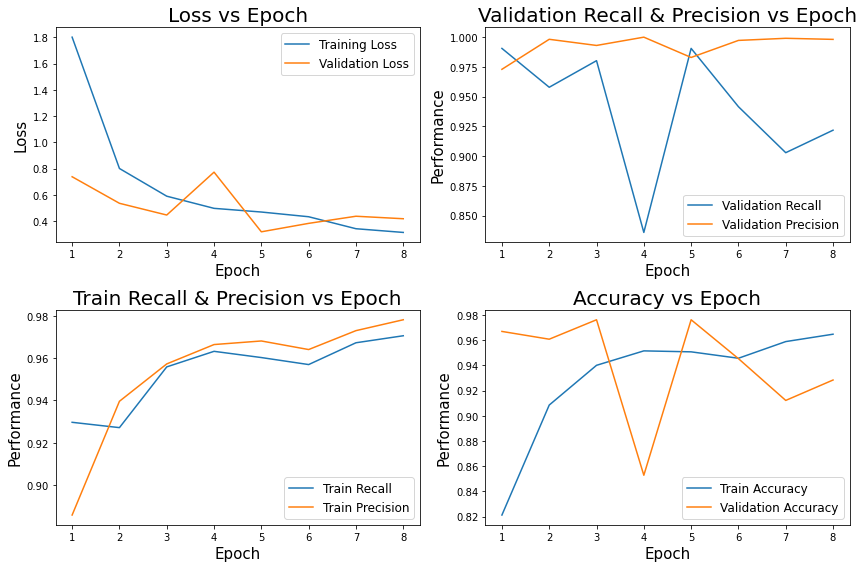

41/41 [==============================] - 13s 313ms/step - loss: 0.4187 - precision: 0.9981 - recall: 0.9218 - accuracy: 0.9284


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.352301,99.802291,92.828244,94.916117
1,Test,0.685398,87.173396,94.102561,87.660259
2,Validation,0.418688,99.813956,92.182130,92.835128


In [15]:
from functions import model_evaluate, train_model, view_history
cnn = {}
# Train model
cnn['Version11'] = train_model(cnn_11, train_gen, val_gen, 20)

# Display history 
view_history(cnn, 'Version11')

# Evaluate model
model_evaluate(cnn_11, train_gen, test_gen, val_gen)

It seems version 11 did better than version 10. Lets keep version 11 and try to do data augmentation with it 

In [16]:
cnn_10.save('models/cnn10.keras')

In [17]:
cnn_11.save("models/cnn11.keras")

# Data Augmentation

I made a function that augments our data and normalizes the data for training. Lets retrive our new data genetors. 

In [18]:
# Call data augmentation fucntion
from functions import data_augmentation

train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(256, 32, train_data_dir, test_data_dir, val_data_dir)

Found 3934 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1298 images belonging to 2 classes.


Now that we have our data generators we can proceed to continue training our cnn10 & cnn 11 models with data augmentation

In [19]:
from tensorflow.keras.models import load_model

model_1 = load_model("models/cnn10.keras")

Epoch 1/20
123/123 [==============================] - 125s 1s/step - loss: 0.9054 - precision: 0.8300 - recall: 0.8459 - accuracy: 0.7738 - val_loss: 0.5782 - val_precision: 0.9653 - val_recall: 0.9553 - val_accuracy: 0.9291
Epoch 2/20
123/123 [==============================] - 124s 1s/step - loss: 0.6731 - precision: 0.9026 - recall: 0.8485 - accuracy: 0.8320 - val_loss: 0.4838 - val_precision: 0.9696 - val_recall: 0.9304 - val_accuracy: 0.9114
Epoch 3/20
123/123 [==============================] - 124s 1s/step - loss: 0.6100 - precision: 0.9078 - recall: 0.8687 - accuracy: 0.8482 - val_loss: 0.7204 - val_precision: 1.0000 - val_recall: 0.6924 - val_accuracy: 0.7242
Epoch 4/20
123/123 [==============================] - 126s 1s/step - loss: 0.5588 - precision: 0.9184 - recall: 0.8691 - accuracy: 0.8561 - val_loss: 0.4400 - val_precision: 0.9871 - val_recall: 0.9184 - val_accuracy: 0.9160
Epoch 5/20
123/123 [==============================] - 126s 1s/step - loss: 0.5108 - precision: 0.934

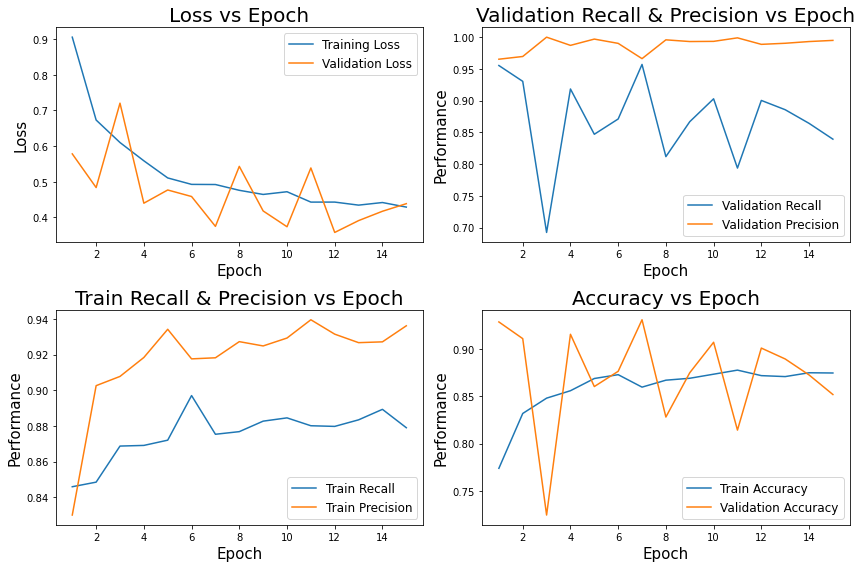

41/41 [==============================] - 11s 270ms/step - loss: 0.4386 - precision: 0.9949 - recall: 0.8393 - accuracy: 0.8521


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.404779,96.410888,85.950714,88.078290
1,Test,0.459096,92.737430,85.128206,86.538464
2,Validation,0.438628,99.490833,83.934706,85.208011


In [21]:
from functions import model_evaluate, view_history, train_model
cnn_aug_model1 = {}
 
# Train the model
cnn_aug_model1['Version1'] = train_model(model_1, train_gen_aug, val_gen_aug, 20)

# Visualize history 
view_history(cnn_aug_model1, 'Version1')

# Evaluate model
model_evaluate(model_1, train_gen_aug, test_gen_aug, val_gen_aug)

In [22]:
# Save our model for augmented training
model_1.save("models/cnn10_aug.keras")

Our losses in our test, train, val are so much better now. In fact there all around the same ballpark suggesting we have good generalization now. Lets try this with cnn11

# CNN AUG Version 2

In [24]:
from tensorflow.keras.models import load_model

model_2 = load_model("models/cnn11.keras")

Epoch 1/20
123/123 [==============================] - 204s 2s/step - loss: 0.8724 - precision: 0.7642 - recall: 0.8941 - accuracy: 0.7361 - val_loss: 0.6540 - val_precision: 0.9119 - val_recall: 0.9338 - val_accuracy: 0.8598
Epoch 2/20
123/123 [==============================] - 204s 2s/step - loss: 0.6554 - precision: 0.8602 - recall: 0.8393 - accuracy: 0.7946 - val_loss: 0.5017 - val_precision: 0.9451 - val_recall: 0.9313 - val_accuracy: 0.8898
Epoch 3/20
123/123 [==============================] - 204s 2s/step - loss: 0.6144 - precision: 0.8707 - recall: 0.8470 - accuracy: 0.8073 - val_loss: 0.4382 - val_precision: 0.9322 - val_recall: 0.9562 - val_accuracy: 0.8983
Epoch 4/20
123/123 [==============================] - 204s 2s/step - loss: 0.5732 - precision: 0.9008 - recall: 0.8312 - accuracy: 0.8200 - val_loss: 0.6577 - val_precision: 0.9113 - val_recall: 0.9089 - val_accuracy: 0.8390
Epoch 5/20
123/123 [==============================] - 203s 2s/step - loss: 0.5568 - precision: 0.891

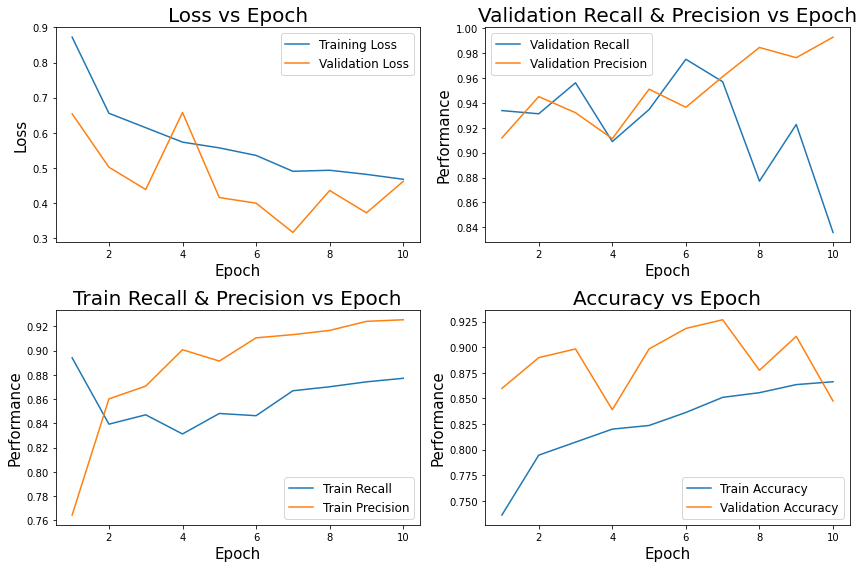

41/41 [==============================] - 13s 309ms/step - loss: 0.4614 - precision: 0.9929 - recall: 0.8359 - accuracy: 0.8475


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.436272,95.950919,86.281723,88.002032
1,Test,0.486208,91.780823,85.897434,86.378205
2,Validation,0.461443,99.285716,83.591068,84.745765


In [25]:
from functions import model_evaluate, view_history, train_model
cnn_aug_model2 = {}

# Train the model
cnn_aug_model2['Version1'] = train_model(model_2, train_gen_aug, val_gen_aug, 20)

# Visualize history 
view_history(cnn_aug_model2, 'Version1')

# Evaluate model
model_evaluate(model_2, train_gen_aug, test_gen_aug, val_gen_aug)

In [26]:
model_2.save("models/cnn11_aug.keras")